In [1]:
!date

Tue Oct 10 09:07:25 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-sim/Code'

In [3]:
%%time
print('importing')
import ants
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

importing


/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


CPU times: user 1.89 s, sys: 918 ms, total: 2.81 s
Wall time: 5min 50s


In [4]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

In [ ]:
  # linear
  #       nearestNeighbor
  #       multiLabel for label images (deprecated, prefer genericLabel)
  #       gaussian
  #       bSpline
  #       cosineWindowedSinc
  #       welchWindowedSinc
  #       hammingWindowedSinc
  #       lanczosWindowedSinc
  #       genericLabel use this for label image

In [90]:
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2,do_plot=True,tmp_dir='/scratch/bergerar/'):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    if do_plot==True:
        temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly',outprefix=tmp_dir) # learns a vector field from small to big sphere
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline') # applies the transformation
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline')
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='nearestNeighbor')
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    if do_plot==True:
        temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22)
        (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map')
        
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    
    #J = ants.create_jacobian_determinant_image(domain_image=warpedBrain,tx=mytx['fwdtransforms'][0])
    #J = J-1
    #J[abs(J.numpy())<.25]=0
    #if do_plot==True:
    #    warpedBrain.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

In [91]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# import os
# from matplotlib import pyplot as plt
# import umap
# from IPython import display
# import time
# import pandas as pd
# from sklearn.metrics import silhouette_score

# import seaborn as sns
#from sklearn.decomposition import PCA
#from umap import UMAP

    

def fit_rsa(rdm_data,rdm_model):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)
    
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec



In [92]:
brain_size = (64,64,64)

In [93]:
temp = ants.image_read('../Misc/Atlas_brain_2mm.nii')
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize()
temp.max()

1.0

## Generate training set

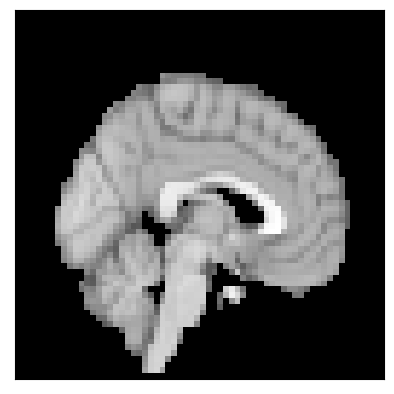

In [49]:
plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);

In [107]:
td_sphere1 = 15
td_sphere2 = 20
TD_brain_big = do_selective_tx(temp,coords = (32,32,32),sz1=td_sphere1,sz2=td_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')

adhd_sphere1 = 15
adhd_sphere2 = 18
ADHD_only_big = do_selective_tx(temp,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
ADHD_brain_big = do_selective_tx(TD_brain,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')

td_sphere1 = 30
td_sphere2 = 25
TD_brain_small = do_selective_tx(temp,coords = (32,32,32),sz1=td_sphere1,sz2=td_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')

adhd_sphere1 = 18
adhd_sphere2 = 15
ADHD_only_small = do_selective_tx(temp,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
ADHD_brain_small = do_selective_tx(TD_brain,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')

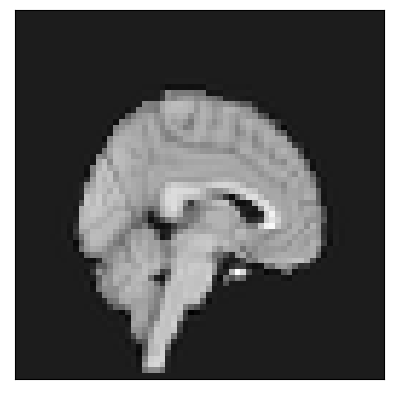

In [114]:
plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/temp.png',transparent=True)

plt.imshow(np.rot90(TD_brain_big.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/TD_brain_big.png',transparent=True)

plt.imshow(np.rot90(ADHD_only_big.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/ADHD_only_big.png',transparent=True)

plt.imshow(np.rot90(ADHD_brain_big.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/ADHD_brain_big.png',transparent=True)

plt.imshow(np.rot90(TD_brain_small.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/TD_brain_small.png',transparent=True)

plt.imshow(np.rot90(ADHD_only_small.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/ADHD_only_small.png',transparent=True)

plt.imshow(np.rot90(ADHD_brain_small.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.savefig('../Figures/BrainExamples/ADHD_brain_small.png',transparent=True)

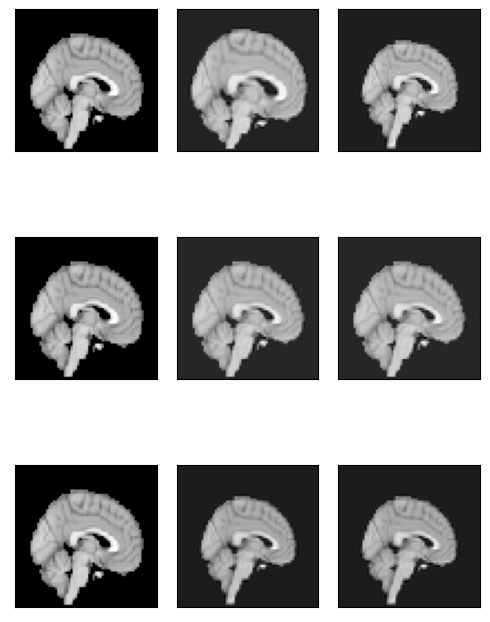

In [109]:
plt.figure(figsize=(5,7.5))
plt.subplot(3,3,1);plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.subplot(3,3,2);plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.subplot(3,3,3);plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);

plt.subplot(3,3,4);plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.subplot(3,3,5);plt.imshow(np.rot90(ADHD_only.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.subplot(3,3,6);plt.imshow(np.rot90(ADHD_only.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);

plt.subplot(3,3,7);plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
plt.subplot(3,3,8);plt.imshow(np.rot90(ADHD_brain.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([])
plt.subplot(3,3,9);plt.imshow(np.rot90(ADHD_brain.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);

plt.tight_layout()

In [121]:
tmp_dir='/scratch/aglinska/'
sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=10, position=(32,32,32))*1.0)
sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=15, position=(32,32,32))*1.0)
mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly',outprefix=tmp_dir) 
im = ants.image_read(mytx['fwdtransforms'][0])


In [175]:
arr = im.numpy()[0::8,0::8,0::8,:]

(8, 8, 3)

In [232]:
x.shape

(5, 5, 5)

/tmp/ipykernel_2679290/3491847873.py:25: RuntimeWarning:

invalid value encountered in true_divide



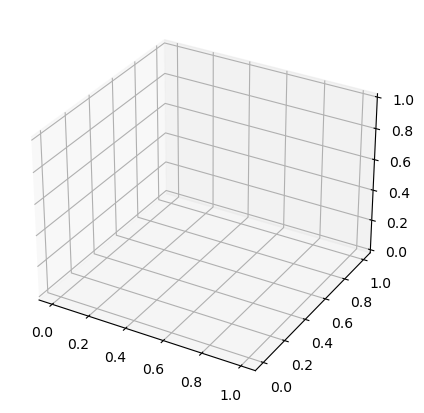

In [276]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')

x, y, z = np.meshgrid(np.arange(-1, 1, 0.3),
                      np.arange(-1, 1, 0.3),
                      np.arange(-1, 1, 0.3))

#x = np.zeros(x.shape)
#y = np.zeros(x.shape)
#z = np.zeros(x.shape)

u=x; v=y; w=z

u = np.zeros(u.shape)
v = np.zeros(u.shape)
w = np.zeros(u.shape)

# Color by azimuthal angle
c = np.arctan2(v, u)
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# Colormap
c = plt.cm.bwr(c)
    
ax.quiver(x, y, z, u, v, w, length=0.12,normalize=True)

In [255]:
ax.quiver?

Signature:
ax.quiver(
    *args,
    length=1,
    arrow_length_ratio=0.3,
    pivot='tail',
    normalize=False,
    **kwargs,
)
Docstring:
ax.quiver(X, Y, Z, U, V, W, /, length=1, arrow_length_ratio=.3, pivot='tail', normalize=False, **kwargs)

Plot a 3D field of arrows.

The arguments could be array-like or scalars, so long as they
they can be broadcast together. The arguments can also be
masked arrays. If an element in any of argument is masked, then
that corresponding quiver element will not be plotted.

Parameters
----------
X, Y, Z : array-like
    The x, y and z coordinates of the arrow locations (default is
    tail of arrow; see *pivot* kwarg).

U, V, W : array-like
    The x, y and z components of the arrow vectors.

length : float, default: 1
    The length of each quiver.

arrow_length_ratio : float, default: 0.3
    The ratio of the arrow head with respect to the quiver.

pivot : {'tail', 'middle', 'tip'}, default: 'tail'
    The part of the arrow that is at the grid poin

In [9]:
# do_generate_data = False

# if do_generate_data:
#     tx_log_td = []
#     tx_log_adhd = []
#     for s in tqdm( range(500) ):
#         sub = f'sub-{s:04d}'
    
#         td_sphere1 = np.random.uniform(low=10.0,high=35,size=1)
#         td_sphere_diff = np.random.uniform(low=-5.0,high=5.0,size=1)
#         td_sphere2 = td_sphere1+td_sphere_diff
#         tx_log_td.append( (td_sphere1,td_sphere2) )
#         #print((td_sphere1,td_sphere2))
    
#         TD_brain = do_selective_tx(temp,coords = (32,32,32),sz1=td_sphere1,sz2=td_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
#         #TD_brain.plot_ortho(flat=True)
    
#         adhd_sphere1 = np.random.uniform(low=5.0,high=15,size=1)
#         adhd_sphere_diff = np.random.uniform(low=-3.0,high=3.0,size=1)
#         adhd_sphere2 = adhd_sphere1+adhd_sphere_diff
#         tx_log_adhd.append( (adhd_sphere1,adhd_sphere2) )
#         #print((adhd_sphere1,adhd_sphere2))
    
#         ADHD_brain = do_selective_tx(TD_brain,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
#         #ADHD_brain.plot_ortho(flat=True)
    
#         #TD_brain.to_filename(os.path.join('../synth-data-01','TD-'+sub+'.nii.gz'))
#         #ADHD_brain.to_filename(os.path.join('../synth-data-01','ADHD-'+sub+'.nii.gz'))
        
#     #np.save(file='../synth-data-01/tx_log_adhd1.npy',arr=np.array(tx_log_adhd)[:,:,0])
#     #np.save(file='../synth-data-01/tx_log_td1.npy',arr=np.array(tx_log_td)[:,:,0])

## Load Training data

In [10]:
data_td = np.array([ants.image_read(f'../synth-data-01/TD-sub-{s:04d}.nii.gz').numpy() for s in tqdm(range(500))])
data_adhd = np.array([ants.image_read(f'../synth-data-01/ADHD-sub-{s:04d}.nii.gz').numpy() for s in tqdm(range(500))])
print(data_td.shape)
print(data_adhd.shape)

100%|█████████████████████████████████████████| 500/500 [02:24<00:00,  3.47it/s]


(500, 64, 64, 64)
(500, 64, 64, 64)


In [11]:
deform_adhd = np.load('../synth-data-01/tx_log_adhd1.npy')
deform_td = np.load('../synth-data-01/tx_log_td1.npy')

In [12]:
df = pd.DataFrame()
df['subID'] = np.hstack( ([f'sub-{s:04d}' for s in range(500)],[f'sub-{s:04d}' for s in range(500)]) )
df['dx'] = np.hstack( (np.repeat(1,500),np.repeat(0,500)) )
df['path'] = np.hstack( ([f'../synth-data-01/ADHD-sub-{s:04d}.nii.gz' for s in range(500)] , [f'../synth-data-01/TD-sub-{s:04d}.nii.gz' for s in range(500)]) )
df['td_sphere_1'] = np.hstack( (deform_td[:,0],deform_td[:,0]) )
df['td_sphere_2'] = np.hstack( (deform_td[:,1],deform_td[:,1]) )
df['adhd_sphere_1'] = np.hstack( (deform_adhd[:,0],np.repeat(0,500)) )
df['adhd_sphere_2'] = np.hstack( (deform_adhd[:,1],np.repeat(0,500)) )
df['td_tx'] = df['td_sphere_1']-df['td_sphere_2']
df['adhd_tx'] = df['adhd_sphere_1']-df['adhd_sphere_2']
#df[''] = np.hstack( (,) )
#df[''] = np.hstack( (,) )
df

,subID,dx,path,td_sphere_1,td_sphere_2,adhd_sphere_1,adhd_sphere_2,td_tx,adhd_tx
0,sub-0000,1,../synth-data-01/ADHD-sub-0000.nii.gz,24.636458,20.592753,12.834489,10.035014,4.043705,2.799475
1,sub-0001,1,../synth-data-01/ADHD-sub-0001.nii.gz,15.945992,12.212052,11.011581,11.316208,3.733940,-0.304627
2,sub-0002,1,../synth-data-01/ADHD-sub-0002.nii.gz,19.401910,15.016307,12.606499,14.643771,4.385604,-2.037272
3,sub-0003,1,../synth-data-01/ADHD-sub-0003.nii.gz,31.737532,26.812256,10.869074,13.482636,4.925275,-2.613562
4,sub-0004,1,../synth-data-01/ADHD-sub-0004.nii.gz,24.533527,25.962776,6.159082,6.337349,-1.429249,-0.178267
...,...,...,...,...,...,...,...,...,...
995,sub-0495,0,../synth-data-01/TD-sub-0495.nii.gz,29.806246,31.775410,0.000000,0.000000,-1.969164,0.000000
996,sub-0496,0,../synth-data-01/TD-sub-0496.nii.gz,14.683680,13.065503,0.000000,0.000000,1.618177,0.000000
997,sub-0497,0,../synth-data-01/TD-sub-0497.nii.gz,18.065294,13.891190,0.000000,0.000000,4.174104,0.000000
998,sub-0498,0,../synth-data-01/TD-sub-0498.nii.gz,14.391185,19.336634,0.000000,0.000000,-4.945449,0.000000


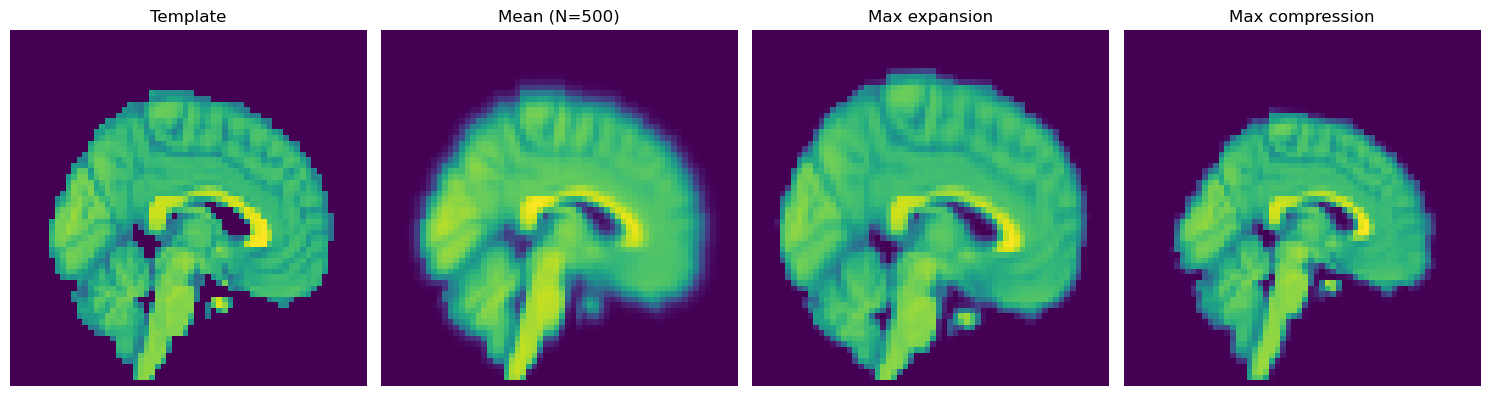

In [13]:
nrows = 1
ncols = 4
c = 0
plt.figure(figsize=(15,5))

c+=1;plt.subplot(nrows,ncols,c)
plt.imshow(np.rot90(temp.numpy()[32,:,:]))
plt.axis('off')
plt.title('Template')

c+=1;plt.subplot(nrows,ncols,c)
plt.imshow(np.rot90(data_adhd.mean(axis=0)[32,:,:]))
plt.axis('off')
plt.title('Mean (N=500)')

c+=1;plt.subplot(nrows,ncols,c)
plt.imshow(np.rot90(data_adhd[df['td_tx'].values.argmin(),32,:,:]))
plt.axis('off')
plt.title('Max expansion')

c+=1;plt.subplot(nrows,ncols,c)
plt.imshow(np.rot90(data_adhd[df['td_tx'].values.argmax(),32,:,:]))
plt.axis('off')
plt.title('Max compression')

# c+=1;plt.subplot(nrows,ncols,c)
# i = (abs(df['td_tx'].values[0:500])-abs(df['adhd_tx'].values[0:500])).argmax()
# plt.imshow(np.rot90(data_adhd[i,32,:,:]))
# plt.axis('off')
# plt.title('S_tx min')

# c+=1;plt.subplot(nrows,ncols,c)
# i = (abs(df['td_tx'].values[0:500])-abs(df['adhd_tx'].values[0:500])).argmin()
# plt.imshow(np.rot90(data_adhd[i,32,:,:]))
# plt.axis('off')
# plt.title('S_tx max')


plt.tight_layout()

In [14]:
data_adhd_flat = data_adhd.reshape(500,-1)

In [15]:
data_adhd_pca = PCA(n_components=10).fit_transform(data_adhd_flat)
data_adhd_pca.shape

(500, 10)

In [41]:
#data_adhd_flat.min()

In [37]:
#adhd_pca = PCA(n_components=10).fit(data_adhd_flat)

In [38]:
#sum(adhd_pca.explained_variance_ratio_)

In [28]:
data_adhd_flat.shape

(500, 262144)

In [16]:
rdm_pca = make_RDM(data_adhd_pca, data_scale='ratio', metric='euclidean')

In [17]:
rdm_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
rdm_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')

Text(0, 0.5, 'Subjects (N=500)')

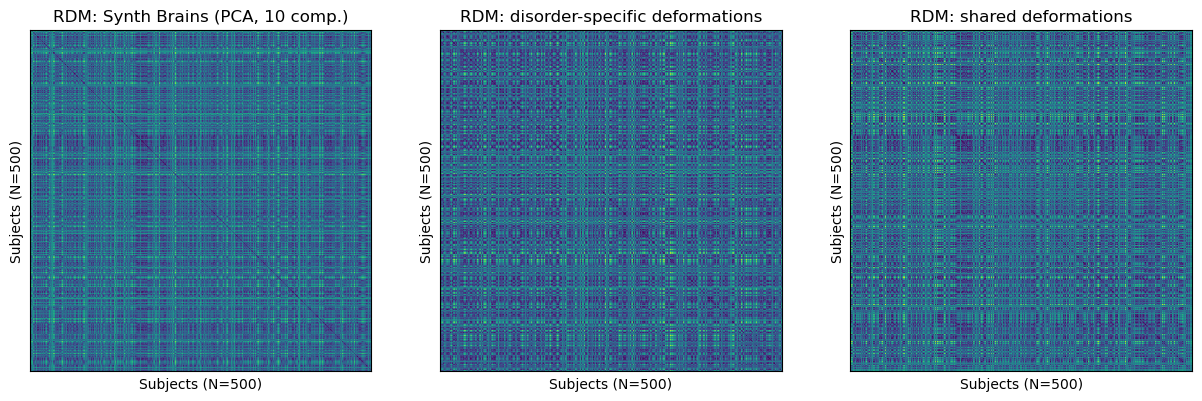

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(rdm_pca);plt.title('RDM: Synth Brains (PCA, 10 comp.)');plt.xticks([]);plt.yticks([]);plt.xlabel('Subjects (N=500)');plt.ylabel('Subjects (N=500)')
plt.subplot(1,3,3);plt.imshow(rdm_z);plt.title('RDM: shared deformations');plt.xticks([]);plt.yticks([]);plt.xlabel('Subjects (N=500)');plt.ylabel('Subjects (N=500)')
plt.subplot(1,3,2);plt.imshow(rdm_s);plt.title('RDM: disorder-specific deformations');plt.xticks([]);plt.yticks([]);plt.xlabel('Subjects (N=500)');plt.ylabel('Subjects (N=500)')

([<matplotlib.axis.XTick at 0x15541170c820>,
 [Text(0, 0, 'TD/ADHD\nCommon Tx'), Text(1, 0, 'ADHD\nspecific TX')])

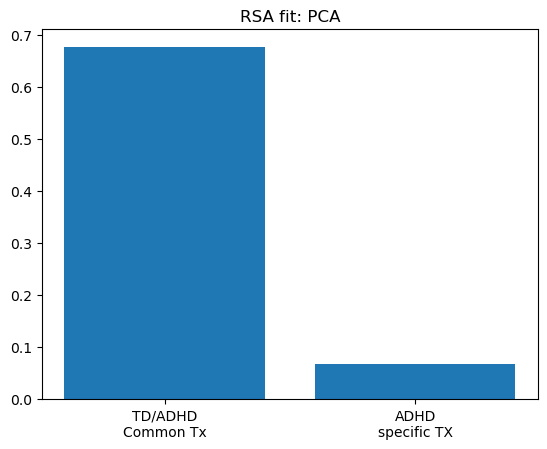

In [19]:
xs = [0,1]
ys = [fit_rsa(rdm_pca,rdm_z),fit_rsa(rdm_pca,rdm_s)]
plt.bar(xs,ys)
plt.title('RSA fit: PCA')
plt.xticks(xs,['TD/ADHD\nCommon Tx','ADHD\nspecific TX'])

In [23]:
ys

[0.6766831080408067, 0.06755159425646705]

Text(0.5, 1.0, 'Permutation test\n Shared TX RSA')

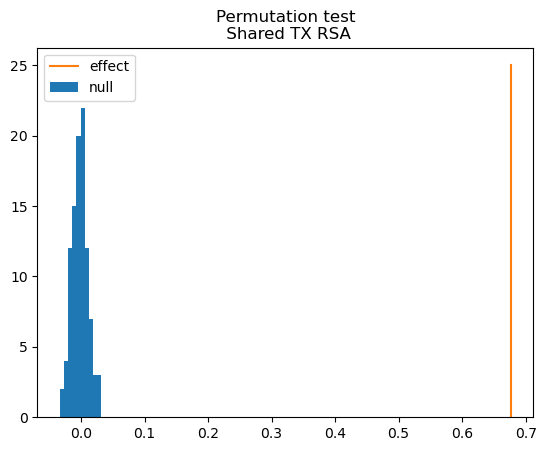

In [20]:
null_rdm_z = [fit_rsa(rdm_pca,make_RDM(np.random.permutation(df.iloc[df['dx'].values==1]['td_tx'].values),data_scale='ratio', metric='euclidean')) for _ in range(100)]
plt.hist(null_rdm_z)
yticks = plt.yticks()
v_xs = (fit_rsa(rdm_pca,rdm_z),fit_rsa(rdm_pca,rdm_z))
v_ys = (yticks[0].min(),yticks[0].max())
plt.plot(v_xs,v_ys,)
plt.legend(['effect','null'])
plt.title('Permutation test\n Shared TX RSA')

Text(0.5, 1.0, 'Permutation test\n Specific TX RSA')

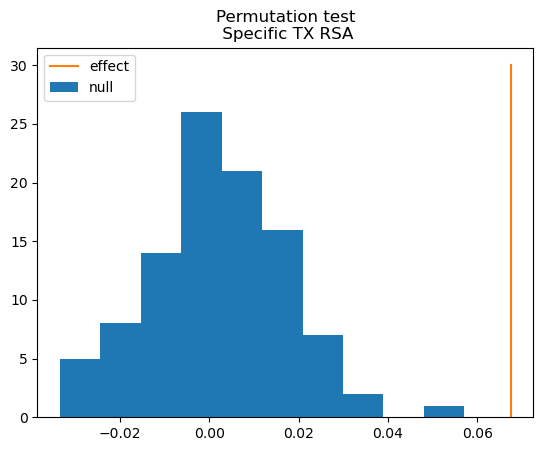

In [21]:
null_rdm_s = [fit_rsa(rdm_pca,make_RDM(np.random.permutation(df.iloc[df['dx'].values==1]['adhd_tx'].values),data_scale='ratio', metric='euclidean')) for _ in range(100)]
plt.hist(null_rdm_s)
yticks = plt.yticks()
v_xs = (fit_rsa(rdm_pca,rdm_s),fit_rsa(rdm_pca,rdm_s))
v_ys = (yticks[0].min(),yticks[0].max())
plt.plot(v_xs,v_ys,)
plt.legend(['effect','null'])
plt.title('Permutation test\n Specific TX RSA')

Text(0.5, 0, 'RSA fit (r)')

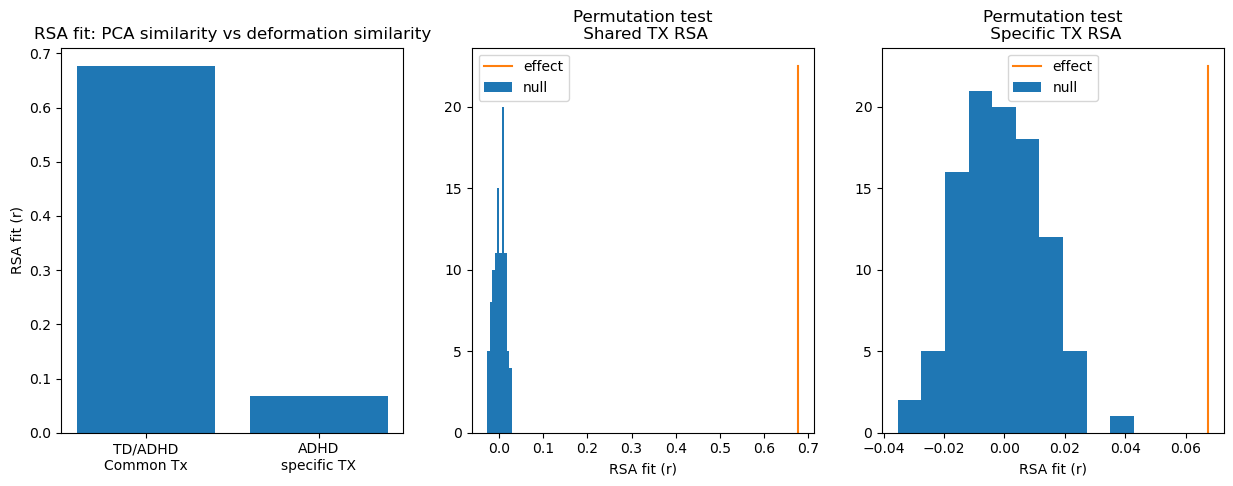

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

xs = [0,1]
ys = [fit_rsa(rdm_pca,rdm_z),fit_rsa(rdm_pca,rdm_s)]
plt.bar(xs,ys)
plt.title('RSA fit: PCA similarity vs deformation similarity')
plt.xticks(xs,['TD/ADHD\nCommon Tx','ADHD\nspecific TX'])
plt.ylabel('RSA fit (r)')

plt.subplot(1,3,2)

null_rdm_z = [fit_rsa(rdm_pca,make_RDM(np.random.permutation(df.iloc[df['dx'].values==1]['td_tx'].values),data_scale='ratio', metric='euclidean')) for _ in range(100)]
plt.hist(null_rdm_z)
yticks = plt.yticks()
v_xs = (fit_rsa(rdm_pca,rdm_z),fit_rsa(rdm_pca,rdm_z))
v_ys = (yticks[0].min(),yticks[0].max())
plt.plot(v_xs,v_ys,)
plt.legend(['effect','null'])
plt.title('Permutation test\n Shared TX RSA')
plt.xlabel('RSA fit (r)')

plt.subplot(1,3,3)

null_rdm_s = [fit_rsa(rdm_pca,make_RDM(np.random.permutation(df.iloc[df['dx'].values==1]['adhd_tx'].values),data_scale='ratio', metric='euclidean')) for _ in range(100)]
plt.hist(null_rdm_s)
yticks = plt.yticks()
v_xs = (fit_rsa(rdm_pca,rdm_s),fit_rsa(rdm_pca,rdm_s))
v_ys = (yticks[0].min(),yticks[0].max())
plt.plot(v_xs,v_ys,)
plt.legend(['effect','null'])
plt.title('Permutation test\n Specific TX RSA')
plt.xlabel('RSA fit (r)')